# Imports 💻💻

In [5]:
!pip install matplotlib

In [2]:
!pip install azure-cognitiveservices-vision-computervision

  Using cached azure_cognitiveservices_vision_computervision-0.9.0-py2.py3-none-any.whl (39 kB)
  Using cached msrest-0.6.21-py2.py3-none-any.whl (85 kB)
  Using cached azure_common-1.1.28-py2.py3-none-any.whl (14 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached isodate-0.6.1-py2.py3-none-any.whl (41 kB)
  Using cached oauthlib-3.2.0-py3-none-any.whl (151 kB)


In [1]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes

from python_code import image_analysis # C'est mon propre code qui comprends la correc !  

In [2]:
import os
import sys
import requests
from io import BytesIO

from array import array
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import time

# [Image Analysis](https://docs.microsoft.com/fr-fr/azure/cognitive-services/computer-vision/overview-image-analysis#image-analysis-features) with the [Computer Vision](https://docs.microsoft.com/fr-fr/azure/cognitive-services/computer-vision/overview) avec [Python](https://docs.microsoft.com/en-us/python/api/azure-cognitiveservices-vision-computervision/azure.cognitiveservices.vision.computervision?view=azure-python) et [API](https://westus.dev.cognitive.microsoft.com/docs/services/computer-vision-v3-2/operations/5d986960601faab4bf452005)

<center><img src="./images/computer_vision.jpg"></center>

* Les questions auxquelles réponds ComputerVision-ImageAnalysis (liste non exhaustive) : 
    - Déterminer si une image contient du contenu pour adultes => `Detect Adult or Racy Content`, 
    - Identifier des célébrités, marques, logo ou des objets spécifiques => `Detect Domain-specific Content, celebrities/landmarks`, `Detect Brands`
    - Attribuer des "étiquettes" aux images ce qui permet de les cataloguer => `Tag Image`, `Categorize Image` => Construire la `target` d'une DB, 
    - Résumer la scène illustrée dans l'image (légendes descriptives) => `Describe Image`, 
    - Trouver des visages humains => `Detect Faces`,  
    - `Detect Color Scheme`
    - `Detect Image Types (clip art/line drawing)`
    - `Detect Objects`
    - `Generate Thumbnail`  
    <br>

* Mise en situation pro : 
    - Par exemple, une entreprise peut décider de mettre en place une WebApp de recherche sur images pour la [Gestion des Actifs Numériques](https://adiict.fr/solutions/digital-asset-management/?gclid=CjwKCAiAgbiQBhAHEiwAuQ6BktmWC947VuPGd_uKm7yKsnov_gZXfXrtlRokotlBrR42ppo6zXjLkhoC_oEQAvD_BwE) (en Anglais DAM pour Digital Asset Management), ce qui nécessite de : 
        - Identifier les images sur la base de logos, de visages, d’objets, de couleurs, ou d’autres éléments.
        - Générer des tags d'images
        - Décrire les images avec sous-titres descriptifs  
    <br>

* Cas réel, [énoncé du projet](https://1drv.ms/w/s!AmJGbSlW18YGs8t_4ucGsP5VrqhTDg)
    * Aurélie Joly (notre contact chez [PassionFroid](https://www.passionfroid.fr/)) possède environ 8000 photos (shooting propres ou achat). 
    * Régulièrement les équipes marketing régionales (11 directions régionales) demandent des visuels qu’ils ont vu dans les catalogues papiers pour faire des posts sur les RS ou pour les transférer à leurs agences locales.
    * Quelle serait la meilleure solution pour mettre à disposition des équipes locales ces photos ?
    * Obj : dev une solution de stockage et recherche pour que les équipes régionales puissent en autonomie trouver les photos et les récupérer
    * La solution doit être transférable vers le dpt marketing nationale qui l’alimentera en photo, le fera vivre

# Create a [Cognitive Services](https://portal.azure.com) Resource

In [12]:
# Q: Lister les abonnements disp ?
!az account list -o tsv

AzureCloud	108bc864-cdf5-4ec3-8b7c-4eb06be1b41d	14c96ffb-9d7c-4aca-b872-adf1f19b250f	True	0	Azure for Students	Enabled	108bc864-cdf5-4ec3-8b7c-4eb06be1b41d	
AzureCloud	604c1504-c6a3-4080-81aa-b33091104187	ec21e509-cad8-4a98-8689-03806a2fc504	False	0	Concierge Subscription	Enabled	604c1504-c6a3-4080-81aa-b33091104187	


In [15]:
# Q : Désigner le compte Student compte par défaut ? 
!az account set --subscription 14c96ffb-9d7c-4aca-b872-adf1f19b250f

In [16]:
# Q: Vérifier ?
!az account list -o table

Name                    CloudName    SubscriptionId                        State    IsDefault
----------------------  -----------  ------------------------------------  -------  -----------
Azure for Students      AzureCloud   14c96ffb-9d7c-4aca-b872-adf1f19b250f  Enabled  True
Concierge Subscription  AzureCloud   ec21e509-cad8-4a98-8689-03806a2fc504  Enabled  False


In [17]:
# Q : Créer un groupe de ressources ?
!az group create --location francecentral --name rg-ia-cog-vision-poc  

{
  "id": "/subscriptions/14c96ffb-9d7c-4aca-b872-adf1f19b250f/resourceGroups/rg-ia-cog-vision-poc",
  "location": "francecentral",
  "managedBy": null,
  "name": "rg-ia-cog-vision-poc",
  "properties": {
    "provisioningState": "Succeeded"
  },
  "tags": null,
  "type": "Microsoft.Resources/resourceGroups"
}


In [2]:
# Q : Lister les ressources de type cognitiveservices ?
!az cognitiveservices account list-kinds

[
  "AnomalyDetector",
  "CognitiveServices",
  "ComputerVision",
  "ContentModerator",
  "ConversationalLanguageUnderstanding",
  "CustomVision.Prediction",
  "CustomVision.Training",
  "Face",
  "FormRecognizer",
  "ImmersiveReader",
  "Internal.AllInOne",
  "LUIS",
  "LUIS.Authoring",
  "LanguageAuthoring",
  "MetricsAdvisor",
  "Personalizer",
  "QnAMaker",
  "QnAMaker.v2",
  "SpeechServices",
  "TextAnalytics",
  "TextTranslation"
]


In [ ]:
# Q : Créer une ressource de type computer vision ?
!az cognitiveservices account create \
    --name cog-plastic-prod \
    --resource-group rg-ia-cog-vision-poc \
    --kind ComputerVision \
    --sku f0 \
    --location westus2 \
    --yes

# Par convention, nom de la ressource : cog-<app name>-<environment>    

# Get the Key and Endpoint for your Cognitive Services resource  🔑

To use your cognitive services resource, client applications need its endpoint and authentication key:

1. In the Azure portal, on the **Keys and Endpoint** page for your cognitive service resource, copy the **Key1** for your resource and paste it in the code below, replacing **YOUR_COG_KEY**.
2. Copy the **endpoint** for your resource and and paste it in the code below, replacing **YOUR_COG_ENDPOINT**.
3. Run the code below.

In [3]:
cog_key = '14f21376a807475db81991bae9a2e1c0'
cog_endpoint = 'https://cog-plastic-prod.cognitiveservices.azure.com/'
print(f'Ready to use cognitive services at {cog_endpoint} using key {cog_key}')

Ready to use cognitive services at https://cog-plastic-prod.cognitiveservices.azure.com/ using key 14f21376a807475db81991bae9a2e1c0


In [4]:
# Get a client for the computer vision service
computervision_client = ComputerVisionClient(cog_endpoint, CognitiveServicesCredentials(cog_key))
computervision_client

# Describe Image

In [6]:
# Get the path to an image file
image_folder = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/smart-cam-supermarket-surveillance/'
image_path = image_folder + 'store_cam2.jpg'

# Get a description from the computer vision service
image_stream = open(image_path, "rb")
description = computervision_client.describe_image_in_stream(image_stream)

# Display image and caption (code in helper_scripts/vision.py)
# image_analysis.describe_image(image_path, description)

In [7]:
for tag in description.tags : 
    print(tag)

text
person
marketplace
store
sale
crowd


In [8]:
for caption in description.captions : 
    print(caption.text)

a person holding a phone


That seems reasonably accurate.

Let's try another image.

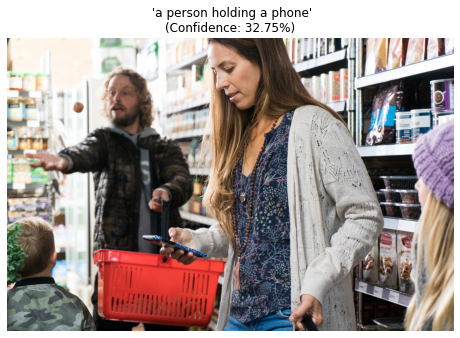

In [24]:
image_path = image_folder + 'store_cam2.jpg'
image_stream = open(image_path, "rb")
description = computervision_client.describe_image_in_stream(image_stream)
image_analysis.describe_image(image_path, description)

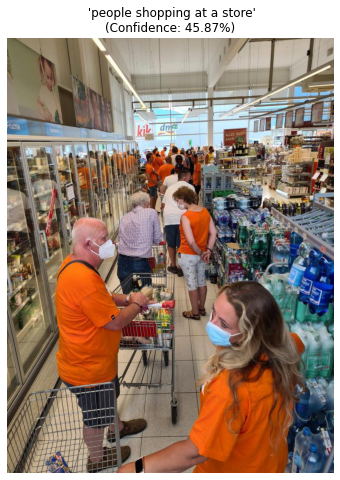

In [10]:
image_path = image_folder + 'store_cam3.jpg'
image_stream = open(image_path, "rb")
description = computervision_client.describe_image_in_stream(image_stream)
image_analysis.describe_image(image_path, description)

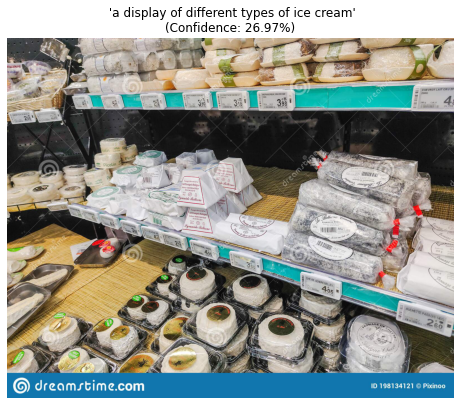

In [11]:
# C'est du fromage alors que le modele prédit ice cream !?
image_path = image_folder + 'store_cam4.jpg'
image_stream = open(image_path, "rb")
description = computervision_client.describe_image_in_stream(image_stream)
image_analysis.describe_image(image_path, description)

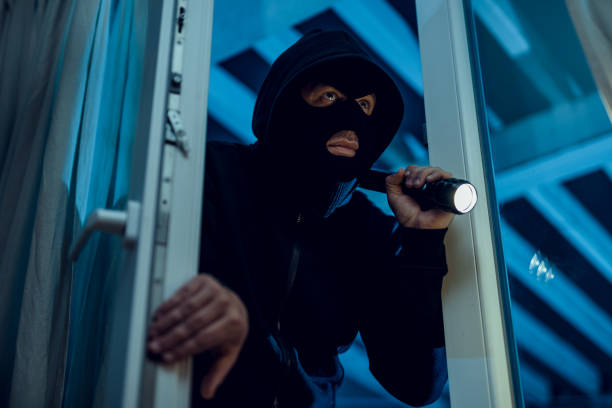

In [4]:
url ="https://media.istockphoto.com/photos/robber-picture-id692119266?k=20&m=692119266&s=612x612&w=0&h=vAa9N8WWLWjEAAGAOyUQJNaoDFgRjDaw3iRupbLbOtY="
img = Image.open(BytesIO(requests.get(url).content))
img

In [8]:
# Get a description from the computer vision service
description = computervision_client. describe_image(url)

for tag in description.tags:
    print(tag)
 
# Display image and caption (code in helper_scripts/vision.py)
# image_analysis.describe_image(BytesIO(requests.get(url).content), description)

person


# Analyze Image Features

So far, you've used the Computer Vision service to generate a descriptive caption for a couple of images; but there's much more you can do. The Computer Vision service provides analysis capabilities that can extract detailed information like:

- The locations of common types of object detected in the image.
- Location and approximate age of human faces in the image.
- Whether the image contains any 'adult', 'racy', or 'gory' content.
- Relevant tags that could be associated with the image in a database to make it easy to find.

In [10]:
# Get the path to an image file
image_folder = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/smart-cam-supermarket-surveillance/'
image_path = image_folder + 'store_cam2.jpg'

# Specify the features we want to analyze
features = ['Description', 'Tags', 'Adult', 'Objects', 'Faces']

# Get an analysis from the computer vision service
image_stream = open(image_path, "rb")
analysis = computervision_client.analyze_image_in_stream(image_stream, visual_features=features)


# Show the results of analysis (code in helper_scripts/vision.py)
# image_analysis.analyze_image(image_path, analysis)

In [11]:
analysis

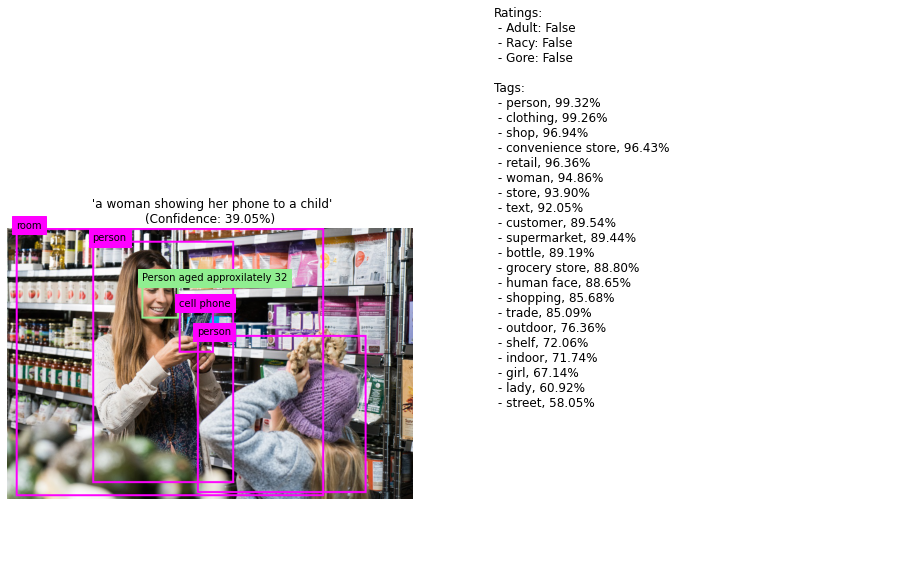

In [5]:
# Get the path to an image file
image_folder = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/smart-cam-supermarket-surveillance/'
image_path = image_folder + 'store_cam1.jpg'

# Specify the features we want to analyze
features = ['Description', 'Tags', 'Adult', 'Objects', 'Faces']

# Get an analysis from the computer vision service
image_stream = open(image_path, "rb")
analysis = computervision_client.analyze_image_in_stream(image_stream, visual_features=features)


# Show the results of analysis (code in helper_scripts/vision.py)
image_analysis.analyze_image(image_path, analysis)

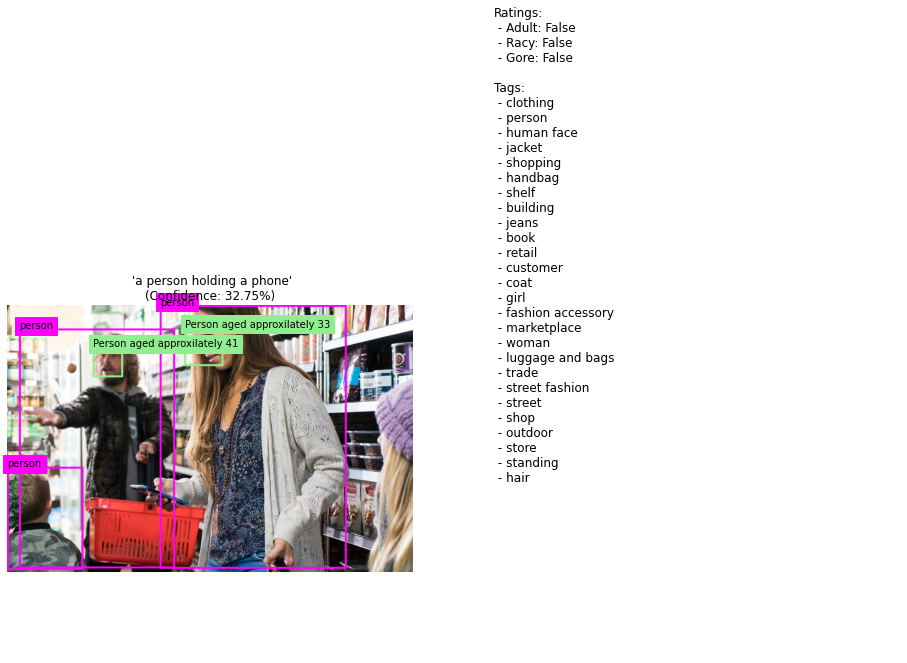

In [13]:
image_path = image_folder + 'store_cam2.jpg'
features = ['Description', 'Tags', 'Adult', 'Objects', 'Faces']
image_stream = open(image_path, "rb")
analysis = computervision_client.analyze_image_in_stream(image_stream, visual_features=features)
image_analysis.analyze_image(image_path, analysis)

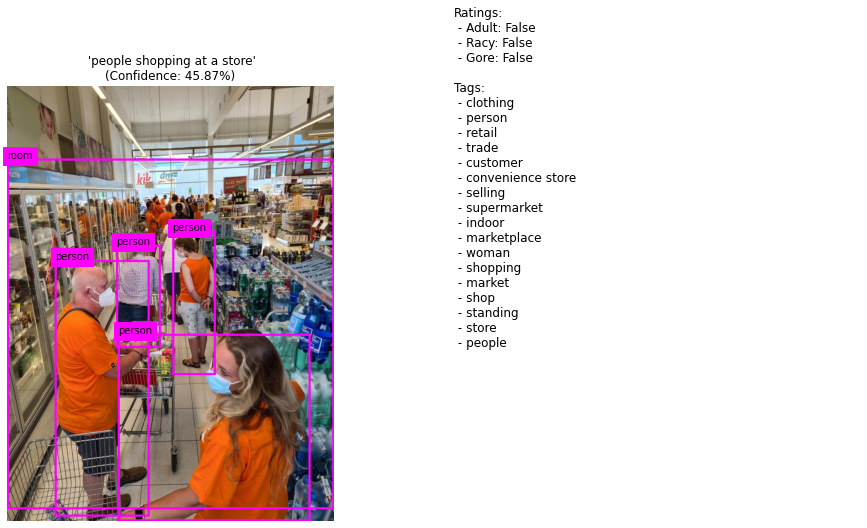

In [22]:
image_path = image_folder + 'store_cam3.jpg'
features = ['Description', 'Tags', 'Adult', 'Objects', 'Faces']
image_stream = open(image_path, "rb")
analysis = computervision_client.analyze_image_in_stream(image_stream, visual_features=features)
image_analysis.analyze_image(image_path, analysis)

# Categorize an Image

* **This example extracts (general) categories from an image**

Categories from image: 
'people_group' with confidence 97.66%


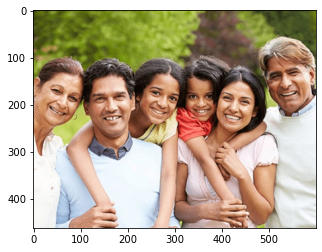

In [21]:
print("===== Categorize an image =====")
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/faces.jpg'
image_stream = open(image_path, "rb")
img = Image.open(image_path)
features = ['categories']
analysis = computervision_client.analyze_image_in_stream(image_stream, visual_features=features)
print("Categories from image: ")
plt.imshow(img)
if (len(analysis.categories) == 0):
    print("No categories detected.")
else:
    for category in analysis.categories:
        print("'{}' with confidence {:.2f}%".format(category.name, category.score * 100))

# Tag an Image

* **This example extracts tags (key word) for each thing in the image**

Tags in the local image: 
'person' with confidence 99.89%
'human face' with confidence 99.74%
'smile' with confidence 99.20%
'outdoor' with confidence 98.60%
'happy' with confidence 96.98%
'clothing' with confidence 96.16%
'friendship' with confidence 94.64%
'tree' with confidence 91.73%
'female person' with confidence 89.10%
'girl' with confidence 88.87%
'social group' with confidence 87.20%
'posing' with confidence 86.55%
'adolescent' with confidence 85.74%
'love' with confidence 85.26%
'laugh' with confidence 85.01%
'people' with confidence 84.99%
'lady' with confidence 84.45%
'woman' with confidence 81.82%
'group' with confidence 79.30%
'wedding' with confidence 61.53%
'dress' with confidence 51.72%


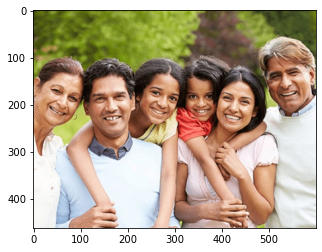

In [23]:
print("===== Tag an Image =====")
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/faces.jpg'
image_stream = open(image_path, "rb")
img = Image.open(image_path)
tags_result = computervision_client.tag_image_in_stream(image_stream)

# Print results with confidence score
print("Tags in the image: ")
if (len(tags_result.tags) == 0):
    print("No tags detected.")
else:
    for tag in tags_result.tags:
        print("'{}' with confidence {:.2f}%".format(tag.name, tag.confidence * 100))
plt.imshow(img)

# Detect Faces

* **This example detects faces in a image, gets their gender and age and marks them with a bounding box**

Faces in the local image: 
'Male' of age 39 at location 118, 159, 212, 253
'Male' of age 54 at location 492, 111, 582, 201
'Female' of age 55 at location 18, 153, 102, 237
'Female' of age 33 at location 386, 166, 467, 247
'Female' of age 18 at location 235, 158, 311, 234
'Female' of age 8 at location 323, 163, 391, 231


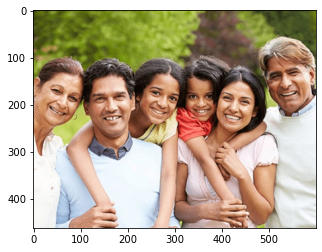

In [8]:
print("===== Detect Faces =====")
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/faces.jpg'
image_stream = open(image_path, "rb")
img = Image.open(image_path)
features = ['faces']
# detect_faces_results = computervision_client.analyze_image_in_stream(image_stream, visual_features=features)
# Print results with confidence score
print("Faces in the local image: ")
if (len(detect_faces_results.faces) == 0):
    print("No faces detected.")
else:
    for face in detect_faces_results.faces:
        print("'{}' of age {} at location {}, {}, {}, {}".format(face.gender, face.age, \
        face.face_rectangle.left, face.face_rectangle.top, \
        face.face_rectangle.left + face.face_rectangle.width, \
        face.face_rectangle.top + face.face_rectangle.height))
plt.imshow(img)

# Detect Adult or Racy Content

* **This example detects adult or racy content in a image, then prints the adult/racy score.**
* **The score is ranged 0.0 - 1.0 with smaller numbers indicating negative results.**

Analyzing local image for adult or racy content ... 
Is adult content: False with confidence 0.14
Has racy content: False with confidence 0.30


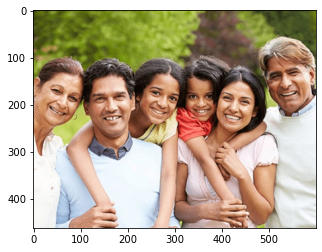

In [9]:
print("===== Detect Adult or Racy Content =====")
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/faces.jpg'
image_stream = open(image_path, "rb")
img = Image.open(image_path)
features = ['adult']
detect_adult_results = computervision_client.analyze_image_in_stream(image_stream, visual_features=features)
# Print results with adult/racy score
print("Analyzing local image for adult or racy content ... ")
print("Is adult content: {} with confidence {:.2f}".format(detect_adult_results.adult.is_adult_content, detect_adult_results .adult.adult_score * 100))
print("Has racy content: {} with confidence {:.2f}".format(detect_adult_results.adult.is_racy_content, detect_adult_results.adult.racy_score * 100))
plt.imshow(img)

* **This example detects the different aspects of its color scheme in an image.**

===== Detect Color =====
Getting color scheme of the local image: 
Is black and white: False
Accent color: 4F5C1A
Dominant background color: White
Dominant foreground color: Brown
Dominant colors: ['White', 'Brown']


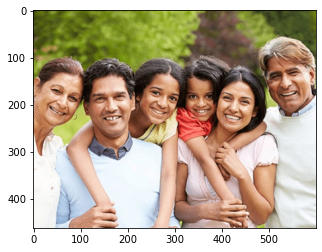

In [10]:
print("===== Detect Color =====")
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/faces.jpg'
img = Image.open(image_path)
image_stream = open(image_path, "rb")
features = ['color']
detect_color_results = computervision_client.analyze_image_in_stream(image_stream, features)

# Print results of the color scheme detected
print("Getting color scheme of the local image: ")
print("Is black and white: {}".format(detect_color_results.color.is_bw_img))
print("Accent color: {}".format(detect_color_results.color.accent_color))
print("Dominant background color: {}".format(detect_color_results.color.dominant_color_background))
print("Dominant foreground color: {}".format(detect_color_results.color.dominant_color_foreground))
print("Dominant colors: {}".format(detect_color_results.color.dominant_colors))
plt.imshow(img)

# Analyze Image by Domain

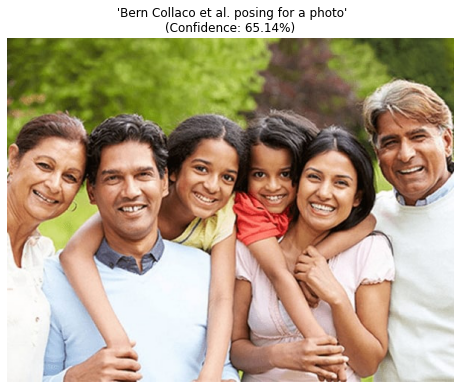

In [12]:
# Déjà la méthode describe_image "basique" fournit de bons résultats
image_folder = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/'
image_path = image_folder + 'faces.jpg'
image_stream = open(image_path, "rb")
description = computervision_client.describe_image_in_stream(image_stream)
image_analysis.describe_image(image_path, description)

* **This example detects celebrites and landmarks in an image**

===== Detect Domain-specific Content  =====
Celebrities in the local image:
Bern Collaco


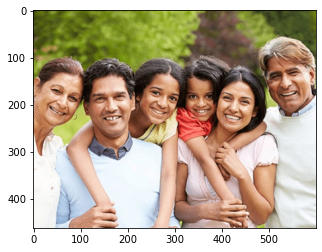

In [15]:
print("===== Detect Domain-specific Content  =====")
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/faces.jpg'
img = Image.open(image_path)
# Open local image file containing a celebtriy
image_stream = open(image_path, "rb")

# Call API with the type of content (celebrities) and local image
detect_domain_results_celebs = computervision_client.analyze_image_by_domain_in_stream("celebrities", image_stream)

# Print which celebrities (if any) were detected
print("Celebrities in the local image:")
if len(detect_domain_results_celebs.result["celebrities"]) == 0:
    print("No celebrities detected.")
else:
    for celeb in detect_domain_results_celebs.result["celebrities"]:
        print(celeb["name"])

plt.imshow(img)

===== Detect Domain-specific Content  =====
Celebrities in the local image:
Steve Ballmer
Satya Nadella
Bill Gates


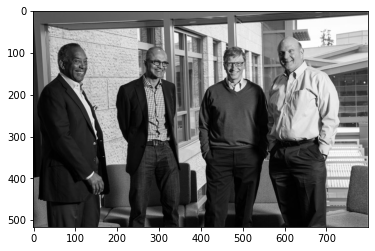

In [16]:
print("===== Detect Domain-specific Content  =====")
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/celebrities.jpg'
img = Image.open(image_path)
# Open local image file containing a celebtriy
image_stream = open(image_path, "rb")

# Call API with the type of content (celebrities) and local image
detect_domain_results_celebs = computervision_client.analyze_image_by_domain_in_stream("celebrities", image_stream)

# Print which celebrities (if any) were detected
print("Celebrities in the local image:")
if len(detect_domain_results_celebs.result["celebrities"]) == 0:
    print("No celebrities detected.")
else:
    for celeb in detect_domain_results_celebs.result["celebrities"]:
        print(celeb["name"])

plt.imshow(img)

* **This example detects celebrites and landmarks in an image**

Landmarks in the local image:
Colosseum


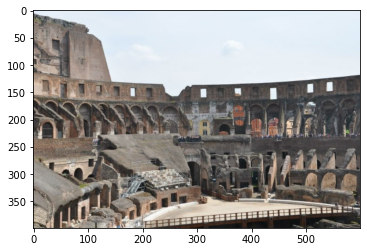

In [17]:
# Open image file containing a landmark
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/landmark.jpg'
image_stream = open(image_path, "rb")
img = Image.open(image_path)
# Call API with type of content (landmark) and local image
detect_domain_results_landmark = computervision_client.analyze_image_by_domain_in_stream("landmarks", image_stream)

# Print results of landmark detected
print("Landmarks in the image:")
if len(detect_domain_results_landmark.result["landmarks"]) == 0:
    print("No landmarks detected.")
else:
    for landmark in detect_domain_results_landmark.result["landmarks"]:
        print(landmark["name"])

plt.imshow(img)

Landmarks in the image:
Taj Mahal


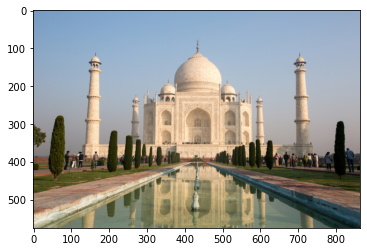

In [19]:
# Open image file containing a landmark
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/landmark.png'
image_stream = open(image_path, "rb")
img = Image.open(image_path)
# Call API with type of content (landmark) and local image
detect_domain_results_landmark = computervision_client.analyze_image_by_domain_in_stream("landmarks", image_stream)

# Print results of landmark detected
print("Landmarks in the image:")
if len(detect_domain_results_landmark.result["landmarks"]) == 0:
    print("No landmarks detected.")
else:
    for landmark in detect_domain_results_landmark.result["landmarks"]:
        print(landmark["name"])

plt.imshow(img)

# Detect Image Types

* **This example detects an image's type (clip art/line drawing)**

===== Detect Image Types - =====
Type of image:
Image is good clip art.
Image is not a line drawing.


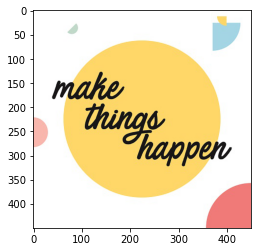

In [22]:
print("===== Detect Image Types - =====")
# Open image
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/type-image.jpg'
image_stream = open(image_path, "rb")
img = Image.open(image_path)
# Select visual feature(s) you want
features = [VisualFeatureTypes.image_type]
# Call API with image and features
detect_type_results = computervision_client.analyze_image_in_stream(image_stream, features)

# Print type results with degree of accuracy
print("Type of image:")
if detect_type_results.image_type.clip_art_type == 0:
    print("Image is not clip art.")
elif detect_type_results.image_type.line_drawing_type == 1:
    print("Image is ambiguously clip art.")
elif detect_type_results.image_type.line_drawing_type == 2:
    print("Image is normal clip art.")
else:
    print("Image is good clip art.")

if detect_type_results.image_type.line_drawing_type == 0:
    print("Image is not a line drawing.")
else:
    print("Image is a line drawing")

plt.imshow(img)

# Detect Objects

* **This example detects different kinds of objects with bounding boxes in a local image**

===== Detect Objects =====
Detecting objects in image:
object at location 213, 365, 85, 208
object at location 218, 402, 179, 384
object at location 238, 417, 298, 416
object at location 116, 419, 60, 386


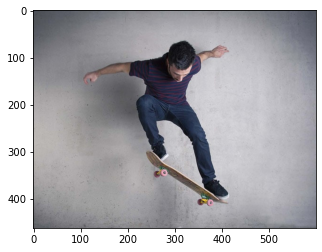

In [25]:
print("===== Detect Objects =====")
# Get image with different objects in it
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/objects.jpg'
image_stream = open(image_path, "rb")
img = Image.open(image_path)

# Call API with image
# detect_objects_results = computervision_client.detect_objects_in_stream(image_stream)

# Print results of detection with bounding boxes
print("Detecting objects in image:")
if len(detect_objects_results.objects) == 0:
    print("No objects detected.")
else:
    for object in detect_objects_results.objects:
        print("object at location {}, {}, {}, {}".format( \
        object.rectangle.x, object.rectangle.x + object.rectangle.w, \
        object.rectangle.y, object.rectangle.y + object.rectangle.h))

plt.imshow(img)

* Draws a bounding box around an object found in image

In [39]:
def drawRectangle(object, draw):
    # Represent all sides of a box
    rect = object.rectangle
    left = rect.x
    top = rect.y
    right = left + rect.w
    bottom = top + rect.h
    coordinates = ((left, top), (right, bottom))
    draw.rectangle(coordinates, outline='red')

* Gets the objects detected in the image

In [38]:
def getObjects(results, draw):
    # Print results of detection with bounding boxes
    print("OBJECTS DETECTED:")
    if len(results.objects) == 0:
        print("No objects detected.")
    else:
        for object in results.objects:
            print("object at location {}, {}, {}, {}".format(
                object.rectangle.x, object.rectangle.x + object.rectangle.w,
                object.rectangle.y, object.rectangle.y + object.rectangle.h))
            drawRectangle(object, draw)
        print()
        print('Bounding boxes drawn around objects... see popup.')

* Prints the tag found from the image


In [41]:
def getTags(results):
    # Print results with confidence score
    print("TAGS: ")
    if (len(results.tags) == 0):
        print("No tags detected.")
    else:
        for tag in results.tags:
            print("'{}' with confidence {:.2f}%".format(
                tag.name, tag.confidence * 100))

* This example detects different kinds of objects with bounding boxes and the tags from the image.

In [40]:
print("===== Analyze Image - Detect objects =====")

# Get image with different objects in it
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/objects.jpg'
image_stream = open(image_path, "rb")

# Opens image to get PIL type of image, for drawing to
image_l = Image.open(image_path)
draw = ImageDraw.Draw(image_l)

# Select visual feature type(s) you want to focus on when analyzing an image
features = ['objects', 'tags']

# Call API with local image to analyze the image
detect_objects_results = computervision_client.analyze_image_in_stream(image_stream, features)

# Show bounding boxes around objects
getObjects(detect_objects_results, draw)
# Print tags from image
getTags(detect_objects_results)

# Display the image in the users default image browser.
image_l.show()

===== Analyze Image =====
OBJECTS DETECTED:
object at location 213, 365, 85, 208
object at location 218, 402, 179, 384
object at location 238, 417, 298, 416
object at location 116, 419, 60, 386

Bounding boxes drawn around objects... see popup.
TAGS: 
'sport' with confidence 99.60%
'person' with confidence 99.56%
'footwear' with confidence 97.92%
'skating' with confidence 96.36%
'boardsport' with confidence 95.59%
'skateboarding equipment' with confidence 94.42%
'skateboarding' with confidence 93.93%
'clothing' with confidence 93.91%
'wall' with confidence 93.63%
'skateboarder' with confidence 93.23%
'individual sports' with confidence 92.93%
'balance' with confidence 90.84%
'street stunts' with confidence 90.83%
'jumping' with confidence 89.91%
'sports equipment' with confidence 88.57%
'extreme sport' with confidence 88.53%
'kickflip' with confidence 88.13%
'stunt' with confidence 87.46%
'skateboard' with confidence 86.42%
'stunt performer' with confidence 86.10%
'sports' with confide

In [43]:
'''
Detect Objects - remote
This example detects different kinds of objects with bounding boxes in a remote image.
'''
from io import BytesIO
print("===== Analyze Image - remote =====")
print()
# Call API with URL to analyze the image
remote_image = "https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/ComputerVision/Images/objects.jpg"
results_remote = computervision_client.analyze_image(remote_image, image_features)

# Download the image from the url, so can display it in popup/browser
object_image = requests.get(remote_image)
image_r = Image.open(BytesIO(object_image.content))
draw = ImageDraw.Draw(image_r)

# Show bounding boxes around objects
getObjects(results_remote, draw)
# Print tags from image
getTags(results_remote)

# Display the image in the users default image browser.
image_r.show()

===== Analyze Image - remote =====

OBJECTS DETECTED:
object at location 213, 365, 85, 208
object at location 218, 402, 179, 384
object at location 238, 417, 298, 416
object at location 116, 419, 60, 386

Bounding boxes drawn around objects... see popup.
TAGS: 
'sport' with confidence 99.60%
'person' with confidence 99.56%
'footwear' with confidence 97.92%
'skating' with confidence 96.36%
'boardsport' with confidence 95.59%
'skateboarding equipment' with confidence 94.42%
'skateboarding' with confidence 93.93%
'clothing' with confidence 93.91%
'wall' with confidence 93.63%
'skateboarder' with confidence 93.23%
'individual sports' with confidence 92.93%
'balance' with confidence 90.84%
'street stunts' with confidence 90.83%
'jumping' with confidence 89.91%
'sports equipment' with confidence 88.57%
'extreme sport' with confidence 88.53%
'kickflip' with confidence 88.13%
'stunt' with confidence 87.46%
'skateboard' with confidence 86.42%
'stunt performer' with confidence 86.10%
'sports' wi

# Detect Brands

* **This example detects common brands like logos and puts a bounding box around them**

===== Detect Brands =====
Detecting brands in local image: 
'Microsoft' brand detected with confidence 62.5% at location 58, 113, 106, 152
'Microsoft' brand detected with confidence 69.8% at location 58, 260, 86, 149


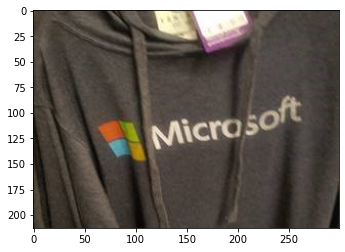

In [27]:
print("===== Detect Brands =====")
# Open image file
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/gray-shirt-logo.jpg'
image_stream = open(image_path, "rb")
img = Image.open(image_path)

# Select the visual feature(s) you want
features = ["brands"]

# Call API with image
# detect_objects_results = computervision_client.analyze_image_in_stream(image_stream, features)

# Print detection results with bounding box and confidence score
print("Detecting brands in local image: ")
if len(detect_objects_results.brands) == 0:
    print("No brands detected.")
else:
    for brand in detect_objects_results.brands:
        print("'{}' brand detected with confidence {:.1f}% at location {}, {}, {}, {}".format( \
        brand.name, brand.confidence * 100, brand.rectangle.x, brand.rectangle.x + brand.rectangle.w, \
        brand.rectangle.y, brand.rectangle.y + brand.rectangle.h))

plt.imshow(img)

# Generate Thumbnail

* **# This example creates a thumbnail from both a local and URL image**

In [29]:
print("===== Generate Thumbnail =====")
# Open image file
image_path = 'C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/objects.jpg'
image_stream = open(image_path, "rb")
img = Image.open(image_path)

print("Generating thumbnail from a local image...")
# Call the API with a local image, set the width/height if desired (pixels)
# Returns a Generator object, a thumbnail image binary (list).
thumb_local = computervision_client.generate_thumbnail_in_stream(100, 100, image_stream, True)

# Write the image binary to file
with open("C:/Users/bejao/OneDrive/data/CognitiveServices/ComputerVision/images/thumb_local.png", "wb") as f:
    for chunk in thumb_local:
        f.write(chunk)

print("Thumbnail saved to local folder.")

===== Generate Thumbnail =====
Generating thumbnail from a local image...


# Learn & Do More


* Explorer l'utilisation de l'API Azure avec Python, PowerShell et avec votre langage préféré ? 